In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

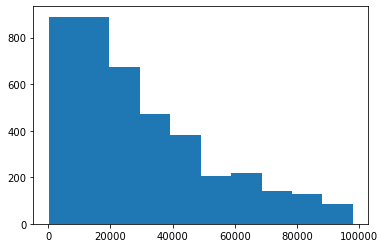

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

#setup y
y_cols = ['Ever Enrolled Count']


    
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys: 
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

X = X/X.std()

#add a categorical value for large vs small mkts
cutoff = 1e5
plt.hist(df['DP03_0095E'][df['DP03_0095E'] < 1e5] )
X['large_mkt'] = 1*(df['DP03_0095E'] > 1e5)

In [3]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=test_size)

In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

mse Ever Enrolled Count    4.587695e+07
dtype: float64


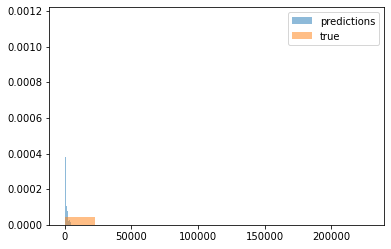

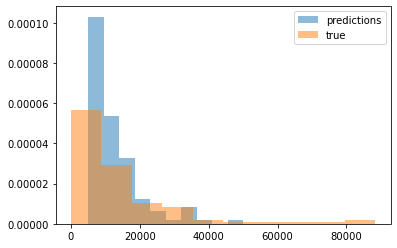

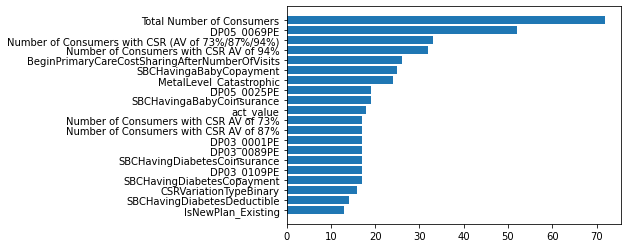

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
UT     22940.021484         13136.200000  19546.240381  10003.414952
MI     17227.789062          6493.000000           NaN           NaN
OK     16783.222656         25732.000000           NaN           NaN
AZ     16568.974609         18344.000000   6933.293530  19592.018196
PA     16556.109375          3234.000000  10949.089992   3104.198769
FL     14948.496094         38621.727273  10495.388519  68461.488986
TX     14166.710938         38095.888889   9961.263717  20139.222958
GA     14144.303711          4172.400000   3478.977251   2789.950770
OH     13580.631836          5398.000000           NaN           NaN
SC     13456.540039          1544.000000           NaN           NaN
IL     12032.392578         66934.000000   2989.990666  30309.425069
NC     11326.846680          3258.000000   4481.298893   3935.756344
LA     11078.858398           292.

In [5]:
# not super deep, but uses most of the data at one
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=2, eta=.5, subsample=0.9, colsample_bytree=.9)
model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
print( 'mse', ((y_test - y_pred)**2).mean() ) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

print(report_error(y_test,y_pred))

mse Ever Enrolled Count    4.603382e+07
dtype: float64


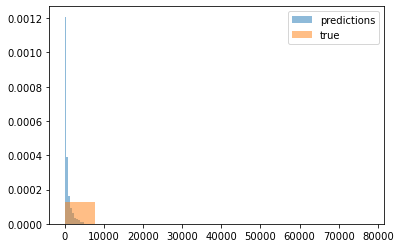

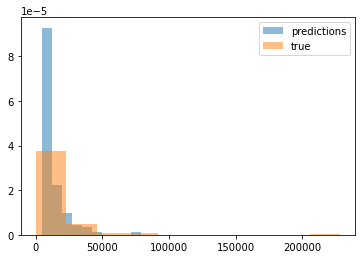

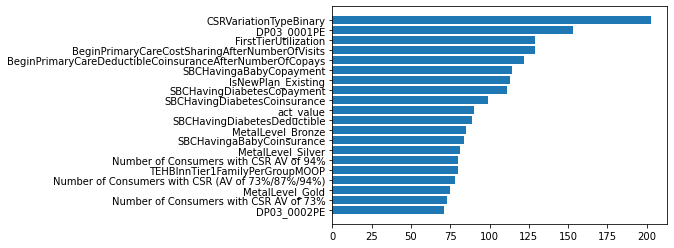

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
FL     22022.812500         34603.214286  21581.052816  60664.388300
MI     20619.507812          6493.000000           NaN           NaN
AZ     19226.031250         22303.500000   4315.114989  25954.354403
UT     18745.591797         10985.333333  12112.031566  10383.256381
NC     15663.998047          6041.000000           NaN           NaN
PA     14842.156250          1039.000000           NaN           NaN
GA     12598.873047         11320.500000   1094.816744  13848.686310
LA     12295.086914           292.000000           NaN           NaN
OK     11231.201172         25732.000000           NaN           NaN
TN     10730.988281           359.000000           NaN           NaN
OR      9366.739258         23895.000000           NaN           NaN
NJ      9086.939453           552.000000           NaN           NaN
IL      8806.498047         30009.

In [6]:
#uses much less data, the covariates seem more accurate...
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=5, eta=.5, subsample=0.5, colsample_bytree=.9)
model.fit(X_train, y_train)

model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
print( 'mse', ((y_test - y_pred)**2).mean() ) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

print(report_error(y_test,y_pred))

alpha_value: 100 mse Ever Enrolled Count    3.487644e+07
dtype: float64


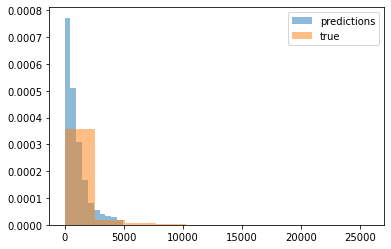

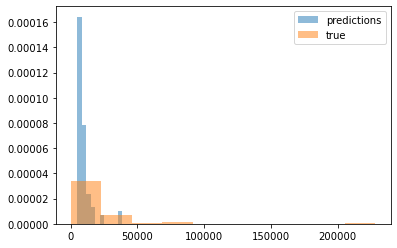

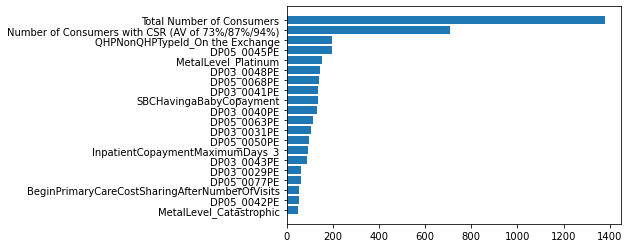

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
FL     17593.309940         39831.230769  13079.726878  61435.872872
IL     15044.468665         66934.000000    231.206885  30309.425069
AZ     12591.270042         22303.500000    292.788783  25954.354403
TX     11253.776204         31096.000000   4615.707017  21906.268634
GA      9717.527284         10032.000000   1273.535075  10400.803206
VA      7775.224555         24490.666667   3283.289601   9991.237377
NC      7417.047033         22278.000000    153.196486   3408.254685
UT      6353.981313         14971.250000   2817.721653  10534.468390
MO      6122.353014         14890.000000           NaN           NaN
PA      5911.122426         17133.000000           NaN           NaN
OR      5774.207941         23895.000000           NaN           NaN
MI      5195.614692         16186.000000           NaN           NaN
OK      3961.206988         25732.

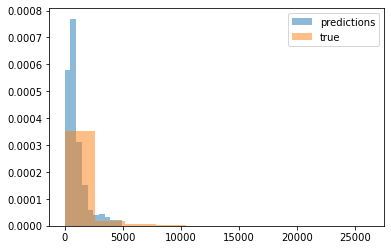

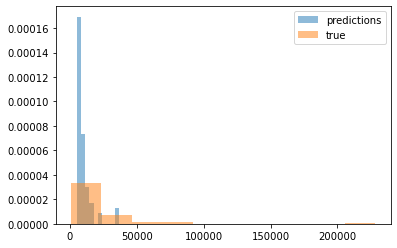

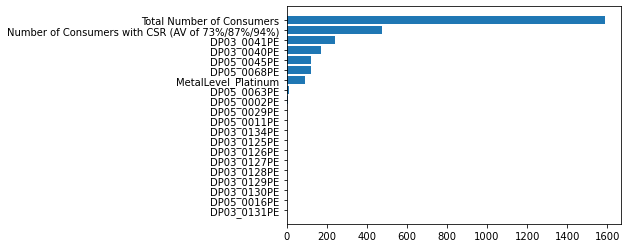

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
FL     15132.209009         41103.384615  13755.228014  60727.092568
IL     15057.014052         66934.000000      0.000000  30309.425069
AZ     12203.270163         22303.500000    193.326472  25954.354403
TX     10577.239785         31096.000000   4616.363375  21906.268634
GA      8933.791683         10032.000000   1055.749076  10400.803206
VA      7558.124430         24490.666667   3293.564007   9991.237377
MO      6089.097506         14890.000000           NaN           NaN
NC      5508.897509         18079.666667   3258.192624   7660.685892
MI      4932.085568         16186.000000           NaN           NaN
OR      4797.754808         23895.000000           NaN           NaN
PA      3821.309404         17133.000000           NaN           NaN
UT      3631.462096         19557.333333   1487.063168   6345.831256
OH      3612.496838         12910.

In [7]:
# Vary alpha values
a = [100,250]#[50,100,150,200,250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,X_test)
    
    print('alpha_value:', i, 'mse', ((y_test - y_pred)**2).mean()) 
    
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()
    print(report_error(y_test,y_pred))
    print('==========================================')
    print('==========================================')

In [8]:
#some training sets total number of consumers?
#some times DP03_CSR?